# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Exploratory Data Analysis: CS109B Final Project F  
## Measuring the shape and brightness of galaxies with neural networks


**Harvard University**<br/>
**Spring 2020**<br/>
**e_group 30**: Ziwei Qiu, Richard Zachary Murray, Hayden Joy, and Daniel Cox   
**Date** 4/9/20

<hr style="height:2pt">

### Data Summary

We have been given a dataset that is a set of 18779 images of simulated galaxies, simulated with the galsim package, along with paramaters associated with each image. The data is dividied into seven arrays.    

    * image  — images 
    * cat    — ? 
    * label  — a set of 5 parameters used in generating the images
    * snr    — signal to noise ratio
    * sigma  — standard deviation of noise
    * image_nonoise — images without noise
    * image_withnoise — images with noise, seems to be the same as image.
    

We have also been given a Jupyter notebook containing code for simulating galaxies.

### Imports

In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import sys
#import os
import math
#import logging
import galsim
import matplotlib.pyplot as plt
import h5py
import numpy as np 
import random 
#import torch 
import copy 
np.set_printoptions(threshold=sys.maxsize)

### Loading Data

In [3]:
f= h5py.File('Data1.h5','r')
image = f['img'][:]    
cat = f['cat'][:]  
label = f['label'][:]   # this gives the set of parameters that characterize the galaxy 
snr = f['snr'][:]
sigma = f['sigma'][:]
image_nonoise = f['img_nonoise'][:]    
image_withnoise = f['img_withnoise'][:]   

### Checking Dimensions

In [4]:
print('image',image.shape)
print('cat',cat.shape)
print('label',label.shape)
print('snr',snr.shape)
print('sigma',sigma.shape)
print('image_nonoise',image_nonoise.shape)
print('image_withnoise',image_withnoise.shape)

image (18779, 64, 64)
cat (18779, 6, 64, 64)
label (18779, 5)
snr (18779,)
sigma (18779,)
image_nonoise (18779, 64, 64)
image_withnoise (18779, 64, 64)


### Let's look at what the image types are.

Here we look at the first 4 images as: image, image_nonoise, image_withnoise and image minus image_withnoise.

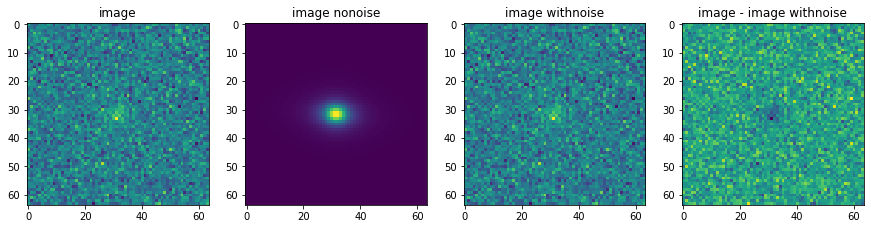

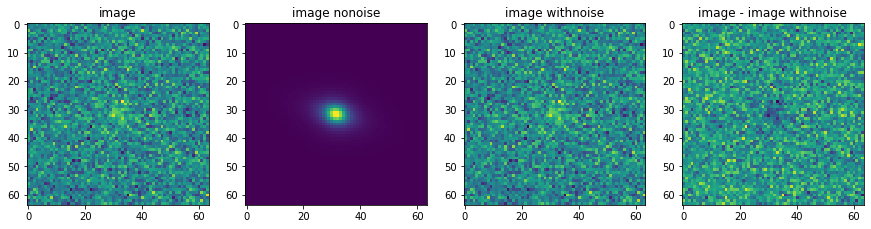

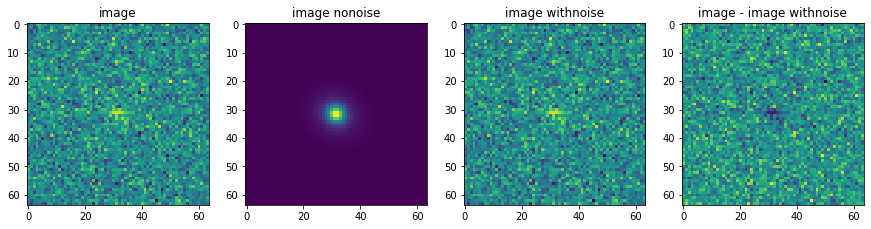

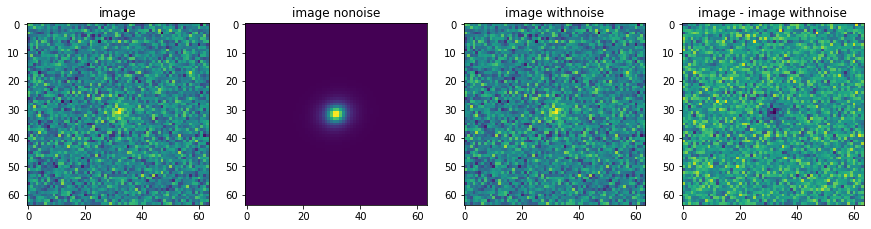

In [6]:
for i in range(4):
    fig,ax = plt.subplots(ncols=4,figsize=(15,5))

    ax[0].imshow(image[i])
    ax[0].set_title("image")
    ax[1].imshow(image_nonoise[i])
    ax[1].set_title("image nonoise")
    ax[2].imshow(image_withnoise[i])
    ax[2].set_title("image withnoise")
    ax[3].imshow(image[i]-image_withnoise[i])
    ax[3].set_title("image - image withnoise")
    
 
    plt.show()

Notes
* So even though image and image_withnoise look simmilar, they are not the same, as they don't subtract to 0.

### Let's look at the cat category, what are these?

First 5 images

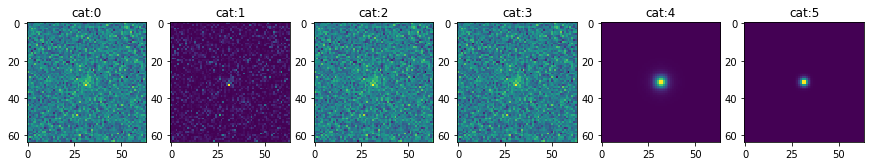

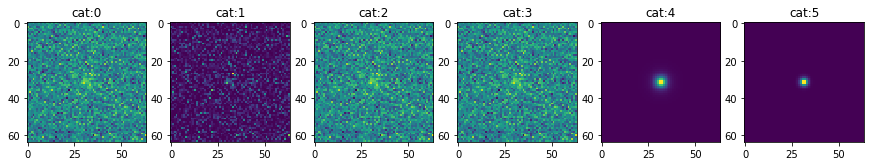

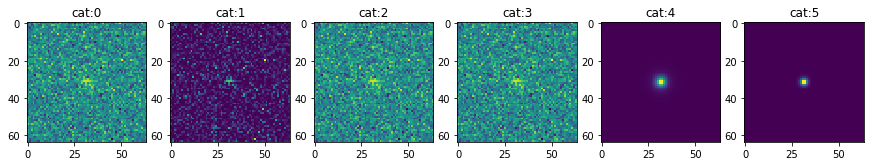

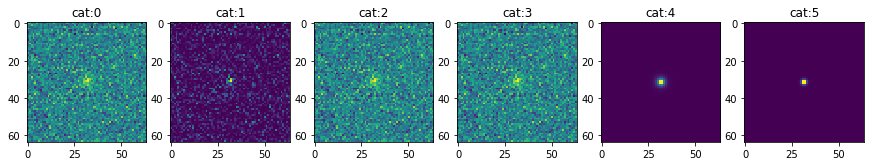

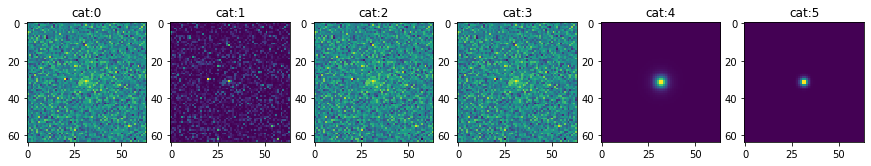

In [7]:
for i in range(5):

    fig,ax = plt.subplots(ncols=6,figsize=(15,5))
    ax[0].imshow(cat[i][0])
    ax[0].set_title("cat:0")
    ax[1].imshow(cat[i][1])
    ax[1].set_title("cat:1")
    ax[2].imshow(cat[i][2])
    ax[2].set_title("cat:2")
    ax[3].imshow(cat[i][3])
    ax[3].set_title("cat:3")
    ax[4].imshow(cat[i][4])
    ax[4].set_title("cat:4")
    ax[5].imshow(cat[i][5])
    ax[5].set_title("cat:5")
    plt.show()

Notes
* Various layers of an image? Hard to say what these are.

### Looking more at the data.

Lets look at a set of 20 random images from the dataset.

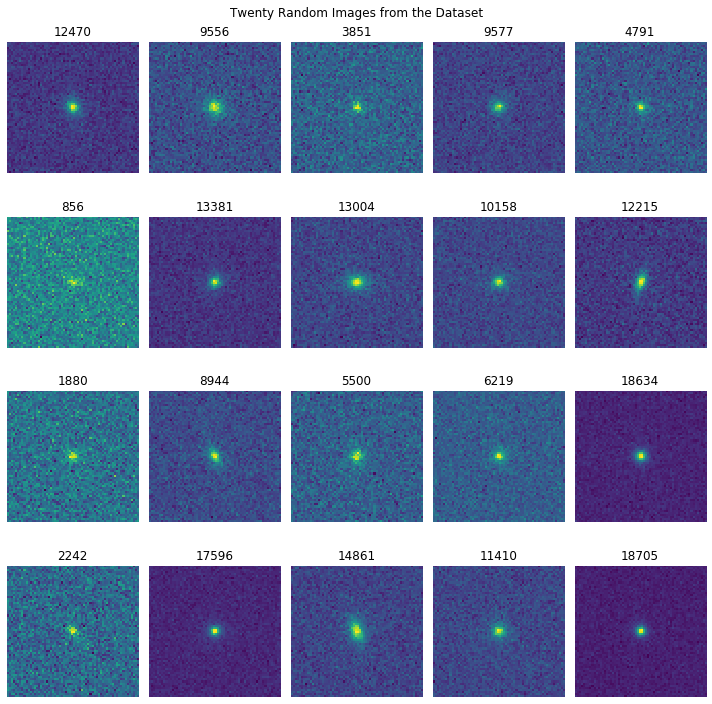

In [6]:
np.random.seed(2020)

nums = np.random.choice(np.arange(18779), size=20, replace=False) 

fig, ax = plt.subplots(4,5, figsize=(10, 10))
images = image[nums]
ax = ax.ravel()
for i, img in enumerate(images):
    ax[i].set_axis_off()
    ax[i].set_title(f'{nums[i]}')
    ax[i].imshow(img)
plt.suptitle('Twenty Random Images from the Dataset', y=1.0)
plt.tight_layout()

Notes:
* All images are centered.
* The level of background noise varies.
* Some are point-like, some are more elongated
* Brightnesses look similar

### Let's look at them without noise

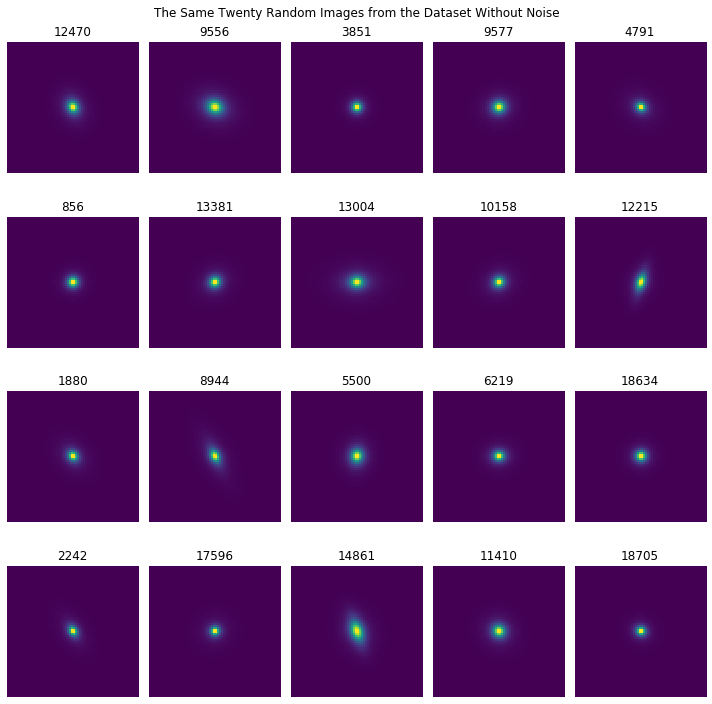

In [7]:
fig, ax = plt.subplots(4,5, figsize=(10, 10))
images = image_nonoise[nums]
ax = ax.ravel()
for i, img in enumerate(images):
    ax[i].set_axis_off()
    ax[i].set_title(f'{nums[i]}')
    ax[i].imshow(img)
plt.suptitle('The Same Twenty Random Images from the Dataset Without Noise', y=1.0)
plt.tight_layout()

Notes:
* Similar brightness
* Some larger radius than others and maybe brighter
* Some point-like some elongated

### Let's look at the distributions of the parameters snr and sigma and see if they are correlated.

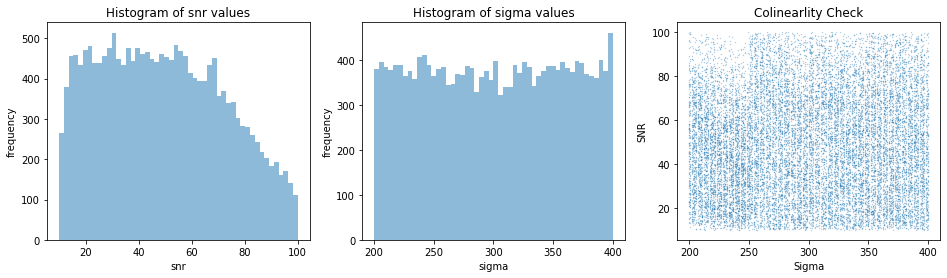

In [11]:
fig, ax = plt.subplots(1,3, figsize=(16, 4))

ax[0].hist(snr, bins=50, alpha=0.5)
ax[0].set_title(f'Histogram of snr values')
ax[0].set_xlabel('snr')
ax[0].set_ylabel('frequency')

ax[1].hist(sigma, bins=50, alpha=0.5)
ax[1].set_xlabel('sigma')
ax[1].set_ylabel('frequency')
ax[1].set_title('Histogram of sigma values')

ax[2].scatter(sigma,snr,s=0.1, alpha=0.5)
ax[2].set_title("Colinearlity Check")
ax[2].set_xlabel("Sigma")
ax[2].set_ylabel("SNR")

plt.show()

Notes:
* snr ranges from ~10 to ~100. The large values fall off in frequency above ~ 55
* sigma ranges from 200 to 400 and appears uniformly distributed
* No obvious correlation between snr and sigma

### Let's look at the distributions of the 5 parameters combined in the array 'label'

In [12]:
# Separating each parmeter into its own array
gal_flux = np.zeros(label.shape[0])
bulge_n = np.zeros(label.shape[0])
bulge_re = np.zeros(label.shape[0])
g_1 = np.zeros(label.shape[0])
g_2 = np.zeros(label.shape[0])
for i, arr in enumerate(list(label)):
    gal_flux[i] = arr[0]
    bulge_n[i] = arr[1]
    bulge_re[i] = arr[2]
    g_1[i] = arr[3]
    g_2[i] = arr[4]  

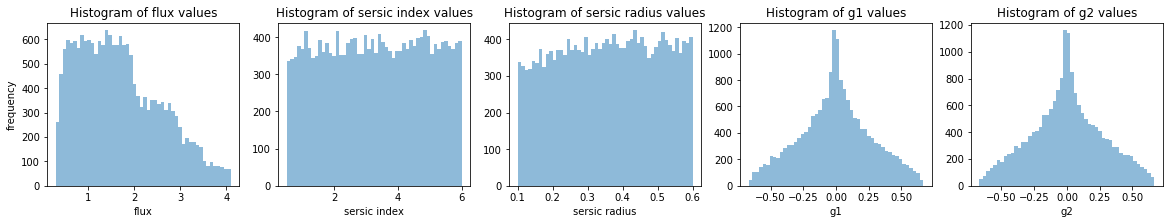

In [13]:
# Making histograms of each parameter in label

fig, ax = plt.subplots(1,5, figsize=(20, 3))

ax[0].hist(gal_flux, bins=50, alpha=0.5)
ax[0].set_title(f'Histogram of flux values')
ax[0].set_xlabel('flux')
ax[0].set_ylabel('frequency')

ax[1].hist(bulge_n, bins=50, alpha=0.5)
ax[1].set_title(f'Histogram of sersic index values')
ax[1].set_xlabel('sersic index')

ax[2].hist(bulge_re, bins=50, alpha=0.5)
ax[2].set_title(f'Histogram of sersic radius values')
ax[2].set_xlabel('sersic radius')

ax[3].hist(g_1, bins=50, alpha=0.5)
ax[3].set_title(f'Histogram of g1 values')
ax[3].set_xlabel('g1')

ax[4].hist(g_2, bins=50, alpha=0.5)
ax[4].set_title(f'Histogram of g2 values')
ax[4].set_xlabel('g2')

plt.show()

Notes:
* flux varies from ~0.3 to 4. It frequency falls off linearly above 2.
* sersic index varys from ~0.5 to 6. It appears uniformly distrubuted. 
* sersic radius varys from ~0.1 to 6. It appears uniformly distrubuted.
* g1 varies from -0.67 to +0.67. Its distribution is symetric with a sharp peak at 0.
* g2 varies from -0.67 to +0.67. Its distribution is symetric with a sharp peak at 0. Its distribution looks like g1.



### Let's see if any of them are correlated.

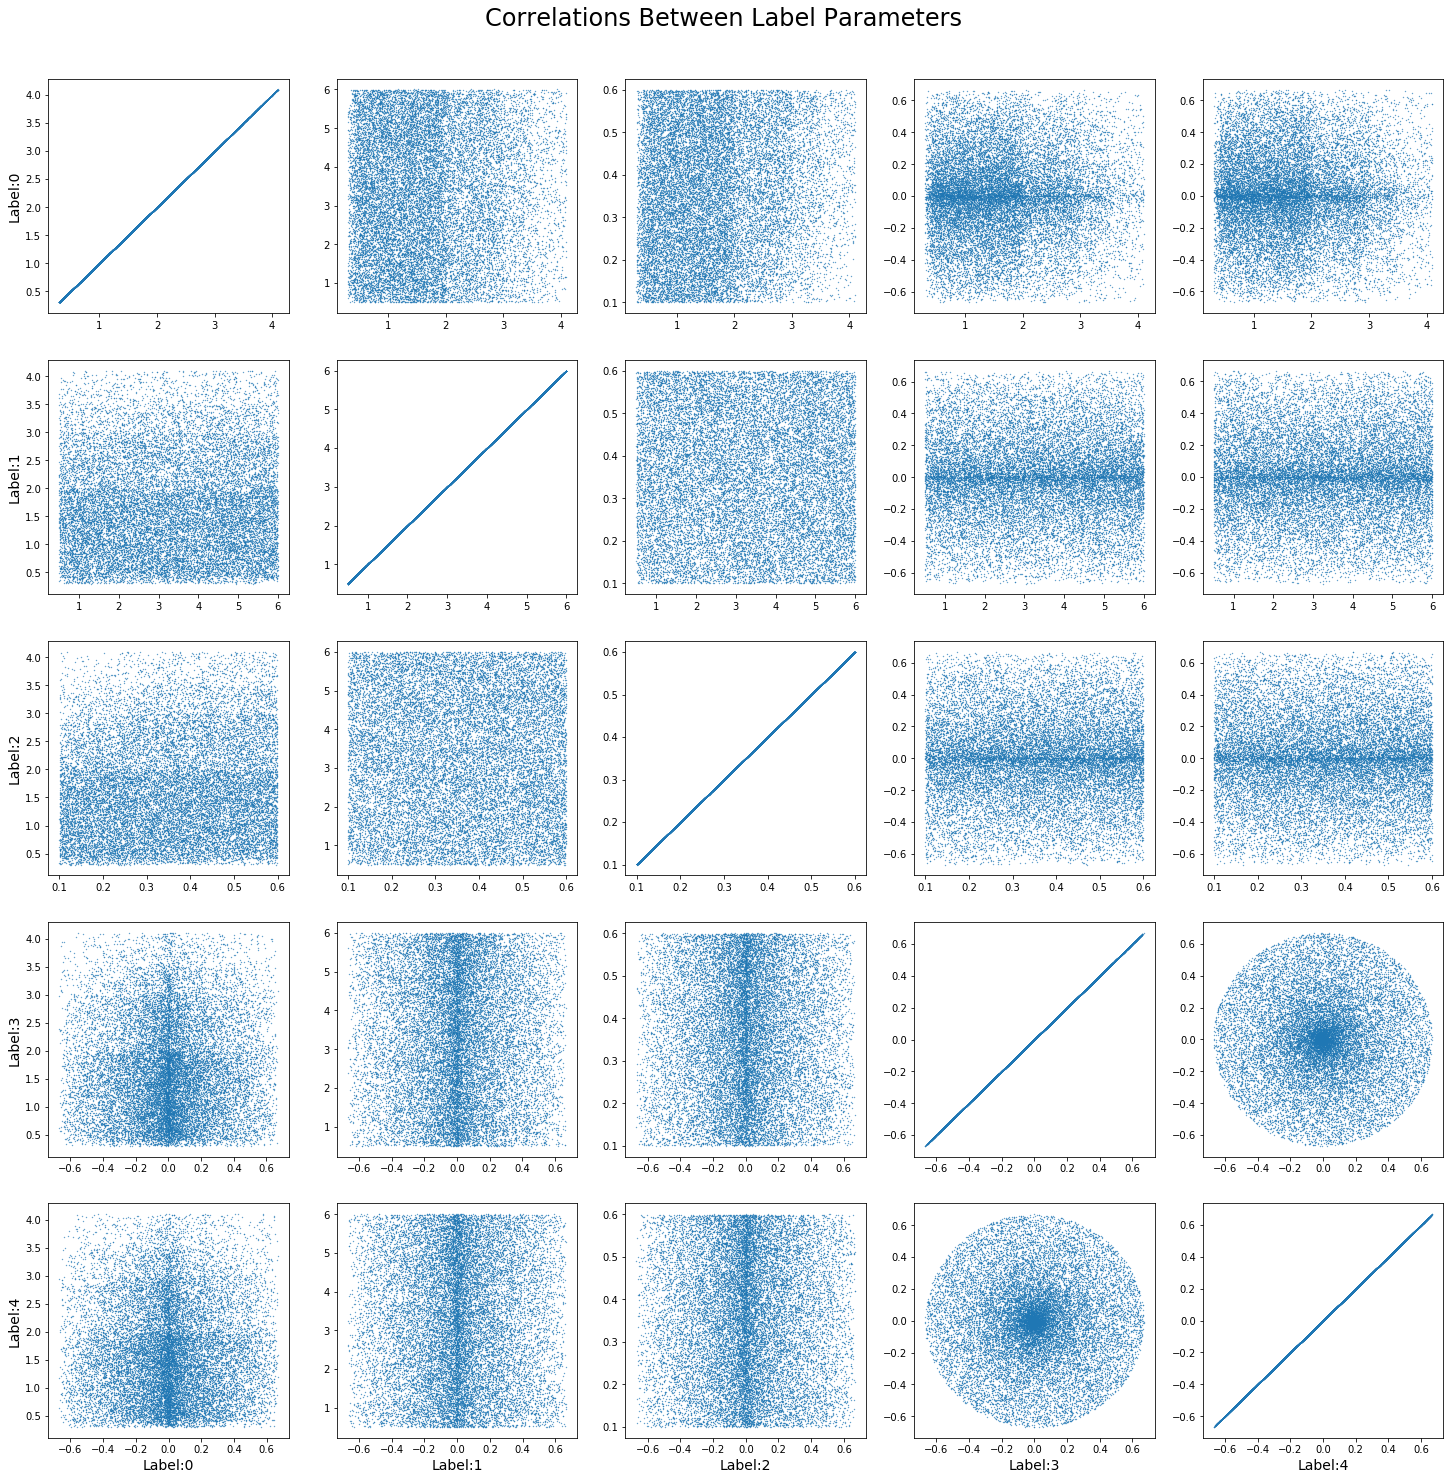

In [24]:
tlabel = label.T

fig,ax = plt.subplots(ncols=len(tlabel),nrows=len(tlabel),figsize=(len(tlabel)*5,len(tlabel)*5))
for i in range(len(tlabel)):
    for j in range(len(tlabel)):
        ax[i,j].scatter(tlabel[i],tlabel[j],s=0.1)
for i in range(len(tlabel)):
    ax[i,0].set_ylabel("Label:"+str(i),fontsize=14)
for j in range(len(tlabel)):
    ax[len(tlabel)-1,j].set_xlabel("Label:"+str(j),fontsize=14)
    
plt.suptitle("Correlations Between Label Parameters",fontsize=24, y=0.92)
plt.show()

Notes
* Interestingly, none of the labels appear correlated except labels 3 & 4. Are these some sort of ellipticity measurments? The pattern is reminiscent of circular polarization and stokes parameters.

### Now, let's vary each of the above 5 paramaters one at a time, holding the others near their mean, and see how varying each effects the galaxies produced.

In [23]:
# function for generating a single galaxy with fixed parameters to use below
def make_galaxy(flux, bulge_n, bulge_re, g1, g2):
    
    size=1
    img_ = np.zeros((size,64,64))
    img_nonoise_ = np.zeros((size,64,64))
    img_2_ = np.zeros((size,64,64))
    gal_flux_ = np.zeros(size)
    bulge_re_ =np.zeros(size)
    bulge_n_ =np.zeros(size)
    gal_q_ = np.zeros(size)
    gal_beta_ = np.zeros(size)
    psf_ =  np.zeros(size)
    snr_ =  np.zeros(size)
    sigma_=  np.zeros(size)
    g_1_= np.zeros(size)
    g_2_= np.zeros(size)

    for i in range(1): 

    # fixed parameters 
        image_size = 64        # n x n pixels
        pixel_scale = 0.23     # arcsec / pixel
        random_seed = 1314662
        rng = galsim.BaseDeviate(random_seed+1)
        psf_beta = 2       #moffat parameter 


    #parameter random generations  
        psf_re=random.uniform(0.5,1)         # PSF moffat scale radius in arcsec 
        bulge_re = bulge_re # random.uniform(0.1,0.6)         # sersic radius, unit arcsec
        bulge_n = bulge_n # random.uniform(0.5,6)        # sersic index 

        # q is ellipticity and beta is orientation. 
        #You could directly predict q and beta but there would be a discontiniuty issue for beta. A jump from 180 degree to 1 degree. 
        # radial sampling for g1 and g2 -reduced shear -> ellipticiy and orientation 
        A= random.uniform(0,0.67)    # gal_q =b/a will ranges in (0.2,1) & A=1-q / 1+q 
        gal_q=(1- A ) /(1+ A ) 
        gal_beta = random.uniform(0,3.14)        #  radians     
        g_1=g1 # A *np.cos(2*gal_beta)
        g_2=g2 # A *np.sin(2*gal_beta)



        noise= random.randint(200,400)
        gal_flux = 1e5* flux # random.uniform(.3,4)

        gal = galsim.Sersic(bulge_n, half_light_radius=bulge_re)
        gal = gal.withFlux(gal_flux )
        gal = gal.shear(g1=g_1,g2=g_2)
        psf = galsim.Moffat(beta=psf_beta, flux=1., fwhm=psf_re)   
        final = galsim.Convolve([psf, gal])
        image = galsim.ImageF(image_size, image_size,scale=pixel_scale)
        final.drawImage(image=image);
        image_nonoise = copy.deepcopy(image.array)
        snr=np.sqrt((image.array**2).sum())/noise #signal to noise ratio, after generating data, choose data with snr [10,100]



        image.addNoise(galsim.PoissonNoise(sky_level=0.))   
        noisemap = np.random.normal(0, noise, 64*64)  #noise map for bkgr gaussian noise
        #noisemap = np.random.normal(0, 300, 64*64)  #noise map for bkgr gaussian noise
        #noisemap = np.full(64*64, 500)  #noise map for bkgr gaussian noise
        
        noisemap=noisemap.reshape((64,64))
        img_fv = image.array+noisemap   #you can also use add noise to add gaussian noise by using 'image.addNoise(galsim.GaussianNoise(sigma=noise)) ' 

        final_2 = psf 
        image_2 = galsim.ImageF(image_size, image_size,scale=pixel_scale)
        final_2.drawImage(image=image_2) 


        img_[i]= img_fv # final noised image 
        img_2_[i]= image_2.array  # psf 
        img_nonoise_[i]=image_nonoise  # noiseless image 
        gal_flux_[i] = gal_flux
        bulge_re_[i] =bulge_re
        bulge_n_[i] =bulge_n
        gal_q_[i] =gal_q
        gal_beta_[i] = gal_beta
        psf_[i]=psf_re
        snr_[i]=snr
        sigma_[i]=noise
        g_1_[i]=g_1
        g_2_[i]=g_2
        
        return img_fv, image_nonoise



### Varying flux

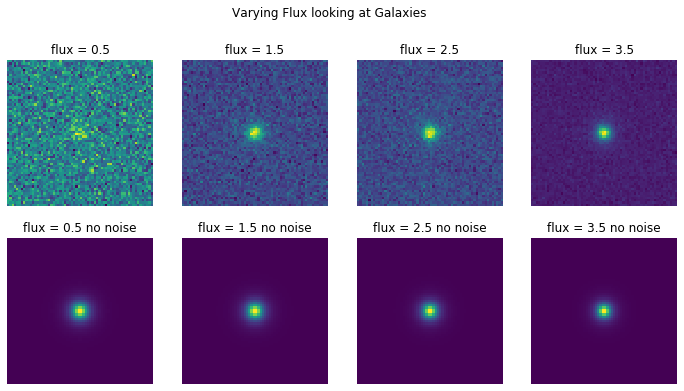

In [12]:
# Varying flux
flux_list = [0.5, 1.5, 2.5, 3.5]
bulge_n = 3
bulge_re = 0.35
g1 = 0
g2 = 0

images_flux = []
images_flux_nonoise = []

for flux in flux_list:
    a, b = make_galaxy(flux, bulge_n, bulge_re, g1, g2)
    images_flux.append(a)
    images_flux_nonoise.append(b)   

fig, ax = plt.subplots(2,4, figsize=(12, 6))

for i in range(4):
    ax[0,i].set_axis_off()
    ax[0,i].set_title(f'flux = {flux_list[i]}')
    ax[0,i].imshow(images_flux[i])

for i in range(4):
    ax[1,i].set_axis_off()
    ax[1,i].set_title(f'flux = {flux_list[i]} no noise')
    ax[1,i].imshow(images_flux_nonoise[i])

    
plt.suptitle('Varying Flux looking at Galaxies ', y=1.0)
plt.show()

Notes varying flux
* Flux appears to effect the amount of signal above the noise.
* But without noise flux looks like it has little effect.

### Varying Sersic index

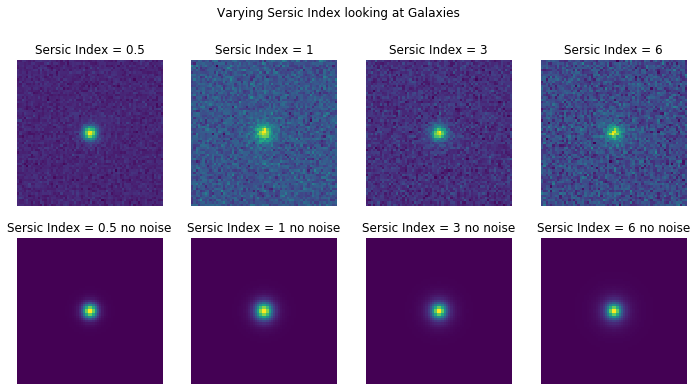

In [14]:
# Varying Sersic index
flux = 2
bulge_n_list = [0.5, 1, 3, 6]
bulge_re = 0.35
g1 = 0
g2 = 0

images_bulge_n = []
images_bulge_n_nonoise = []

for bulge_n in bulge_n_list:
    a, b = make_galaxy(flux, bulge_n, bulge_re, g1, g2)
    images_bulge_n.append(a)
    images_bulge_n_nonoise.append(b)   

fig, ax = plt.subplots(2,4, figsize=(12, 6))

for i in range(4):
    ax[0,i].set_axis_off()
    ax[0,i].set_title(f'Sersic Index = {bulge_n_list[i]}')
    ax[0,i].imshow(images_bulge_n[i])

for i in range(4):
    ax[1,i].set_axis_off()
    ax[1,i].set_title(f'Sersic Index = {bulge_n_list[i]} no noise')
    ax[1,i].imshow(images_bulge_n_nonoise[i])

    
plt.suptitle('Varying Sersic Index looking at Galaxies ', y=1.0)
plt.show()

Notes varying sersic index
* It seems like maybe as the index increases the galaxies are a little blurrier.


### Varying Sersic radius

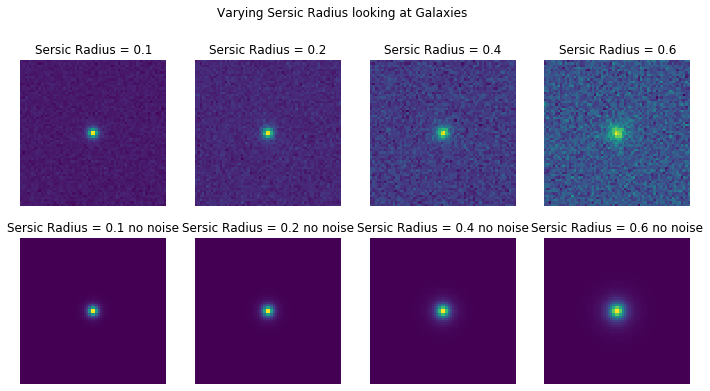

In [17]:
# Varying Sersic radius
flux = 2
bulge_re_list = [0.1, 0.2, 0.4, 0.6]
bulge_n = 3
g1 = 0
g2 = 0

images_bulge_re = []
images_bulge_re_nonoise = []

for bulge_re in bulge_re_list:
    a, b = make_galaxy(flux, bulge_n, bulge_re, g1, g2)
    images_bulge_re.append(a)
    images_bulge_re_nonoise.append(b)   

fig, ax = plt.subplots(2,4, figsize=(12, 6))

for i in range(4):
    ax[0,i].set_axis_off()
    ax[0,i].set_title(f'Sersic Radius = {bulge_re_list[i]}')
    ax[0,i].imshow(images_bulge_re[i])

for i in range(4):
    ax[1,i].set_axis_off()
    ax[1,i].set_title(f'Sersic Radius = {bulge_re_list[i]} no noise')
    ax[1,i].imshow(images_bulge_re_nonoise[i])

    
plt.suptitle('Varying Sersic Radius looking at Galaxies ', y=1.0)
plt.show()

Notes varying sersic radius
* signal to noise appears to get worse as sersic radius increases 
* Also, with or without the noise the radius of the galaxy increases with sersic radius

### Varying g1

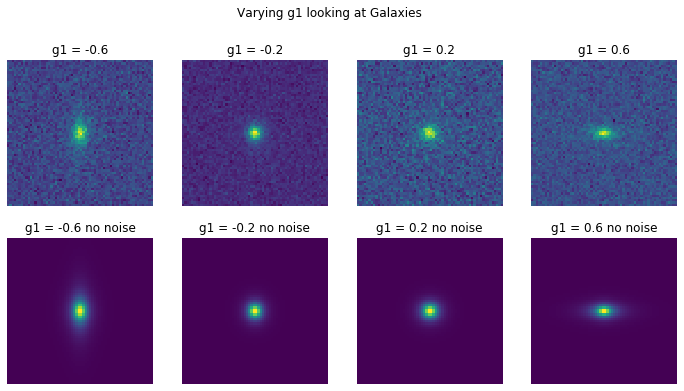

In [18]:
# Varying g1
flux = 2
bulge_n = 3
bulge_re = 0.35
g1_list = [-0.6, -0.2, 0.2, 0.6]
g2 = 0

images_g1 = []
images_g1_nonoise = []

for g1 in g1_list:
    a, b = make_galaxy(flux, bulge_n, g1, g1, g2)
    images_g1.append(a)
    images_g1_nonoise.append(b)   

fig, ax = plt.subplots(2,4, figsize=(12, 6))

for i in range(4):
    ax[0,i].set_axis_off()
    ax[0,i].set_title(f'g1 = {g1_list[i]}')
    ax[0,i].imshow(images_g1[i])

for i in range(4):
    ax[1,i].set_axis_off()
    ax[1,i].set_title(f'g1 = {g1_list[i]} no noise')
    ax[1,i].imshow(images_g1_nonoise[i])

    
plt.suptitle('Varying g1 looking at Galaxies ', y=1.0)
plt.show()

Notes varying g1
* The extreme negative valued galaxy is elongated vertically.
* The extreme positive valued galaxy is elongated horizontally.
* The middle valued galaxies are similarly round.

### Varying g2

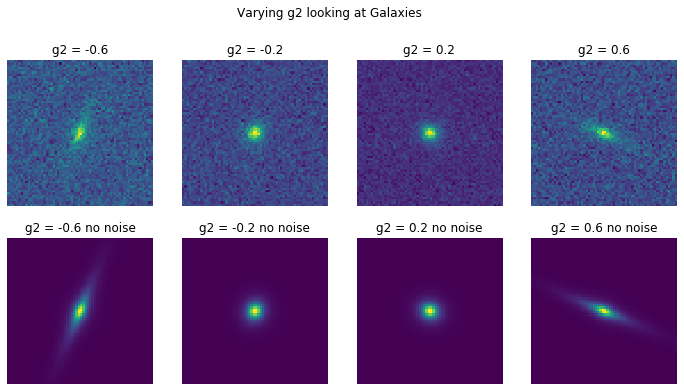

In [24]:
# Varying g2
flux = 2
bulge_n = 3
bulge_re = 0.35
g2_list = [-0.6, -0.2, 0.2, 0.6]
g1 = 0

images_g2 = []
images_g2_nonoise = []

for g2 in g2_list:
    a, b = make_galaxy(flux, bulge_n, g2, g2, g2)
    images_g2.append(a)
    images_g2_nonoise.append(b)   

fig, ax = plt.subplots(2,4, figsize=(12, 6))

for i in range(4):
    ax[0,i].set_axis_off()
    ax[0,i].set_title(f'g2 = {g2_list[i]}')
    ax[0,i].imshow(images_g2[i])

for i in range(4):
    ax[1,i].set_axis_off()
    ax[1,i].set_title(f'g2 = {g2_list[i]} no noise')
    ax[1,i].imshow(images_g2_nonoise[i])

    
plt.suptitle('Varying g2 looking at Galaxies ', y=1.0)
plt.show()

Notes varying g2
* The extreme negative-valued galaxy is quite elongated in a diagonal positve sloping way.
* The extreme positive-valued galaxy is quite elongated in a diagonal negative sloping way. It is not the mirror image of the extreme negative-valued galaxy, although they are similarly elongated.
* The middle valued galaxies at -0.2 and +0.2, do not appear elongated. Also, they are not the same diameter, but we find their relative diameters changes from run to run of this cell.

### Summary of label parameters

We have looked up the definitions of these paramaters: 

* Flux — brightness divided by area
* Sérsic index — controls the degree of curvature of the galaxy profile.
* Sérsic radius — half_light radius
* g1 — orientation
* g2 — elipticity 

For the most part these definitions align well with our observations. Although the we did not clearly see the change in brightness that is expected with changing flux, we did see changes in ellipticity and orientation with g1 and g2, changes in radius with changes in sersic radius, and changes in blurriness with changes in sersic index.